In [73]:
import numpy as np
import rasterio as rio
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.ops import cascaded_union
from shapely.geometry.polygon import Polygon
from cartopy.feature import ShapelyFeature
import matplotlib.patches as mpatches

In [74]:
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

In [75]:
def percentile_stretch(img, pmin=0., pmax=100.):
    '''
    This is where you should write a docstring.
    '''
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    # here, we make sure that the image is only 2-dimensional
    if not img.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')

    minval = np.percentile(img, pmin)
    maxval = np.percentile(img, pmax)

    stretched = (img - minval) / (maxval - minval)  # stretch the image to 0, 1
    stretched[img < minval] = 0  # set anything less than minval to the new minimum, 0.
    stretched[img > maxval] = 1  # set anything greater than maxval to the new maximum, 1.

    return stretched

In [76]:
def img_display(img, ax, bands, stretch_args=None, **imshow_args):
    '''
    This is where you should write a docstring.
    '''
    dispimg = img.copy().astype(np.float32)  # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(img.shape[0]):  # loop over each band, stretching using percentile_stretch()
        if stretch_args is None:  # if stretch_args is None, use the default values for percentile_stretch
            dispimg[b] = percentile_stretch(img[b])
        else:
            dispimg[b] = percentile_stretch(img[b], **stretch_args)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])

    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], **imshow_args)

    return handle, ax

In [77]:
with rio.open('data_files/NI_Mosaic.tif') as dataset:
    img = dataset.read()
    xmin, ymin, xmax, ymax = dataset.bounds

In [78]:
#display raster information
print('{} openend in {} mode'.format(dataset.name,dataset.mode))
print('image has {} band(s)'.format(dataset.count))
print('image size (width, height): {} x {}'.format(dataset.width, dataset.height))
print('band 1 datatype is {}'.format(dataset.dtypes[0]))
print(dataset.bounds)
print(dataset.crs)

data_files/NI_Mosaic.tif openend in r mode
image has 7 band(s)
image size (width, height): 1850 x 1500
band 1 datatype is int16
BoundingBox(left=550000.0, bottom=5985000.0, right=735000.0, top=6135000.0)
EPSG:32629


In [79]:
#import county vector data, check columns and CRS
counties = gpd.read_file('data_files/counties.shp')
print(counties.head())
counties.crs

   COUNTY_ID   CountyName    Area_SqKM  OBJECTID  \
0          6       TYRONE  3265.796622         1   
1          1       ANTRIM  3097.847750         2   
2          2       ARMAGH  1327.228438         3   
3          4    FERMANAGH  1850.832538         4   
4          5  LONDONDERRY  2118.316853         5   

                                            geometry  
0  POLYGON ((-7.38177 54.94208, -7.38170 54.94201...  
1  MULTIPOLYGON (((-5.95296 54.55222, -5.95298 54...  
2  POLYGON ((-6.35398 54.50927, -6.35191 54.50891...  
3  POLYGON ((-7.69417 54.60511, -7.69390 54.60498...  
4  POLYGON ((-6.66919 55.19899, -6.66918 55.19893...  


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [80]:
#import towns vector data, check columns and CRS
towns = gpd.read_file('data_files/NI_towns.shp')
print(towns.head())
towns.crs

   TOWN_NAME  X_COORD  Y_COORD STATUS  town_city  \
0   Strabane   234500   397700   Town          0   
1     Antrim   315300   387000   Town          0   
2     Armagh   287600   345500   City          1   
3  Ballymena   310700   403400   Town          0   
4  Banbridge   312700   346200   Town          0   

                        geometry  
0  POINT (234500.000 397700.000)  
1  POINT (315300.000 387000.000)  
2  POINT (287600.000 345500.000)  
3  POINT (310700.000 403400.000)  
4  POINT (312700.000 346200.000)  


<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [81]:
#change CRS of vector datasets to match raster(UTM 29 EPGS32629)
counties=counties.to_crs(epsg=32629)
towns=towns.to_crs(epsg=32629)

In [82]:
#check CRS of vector layers
counties.crs = towns.crs


In [83]:
#define my CRS
myCRS = ccrs.UTM(29) 

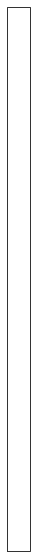

In [84]:
# create a figure of size 10x10 (representing the page size in inches), plotted on axis
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=myCRS))

In [85]:
# add gridlines below
gridlines = ax.gridlines(draw_labels=True,
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5],
                         ylocs=[54, 54.5, 55, 55.5])
gridlines.right_labels = False
gridlines.bottom_labels = False

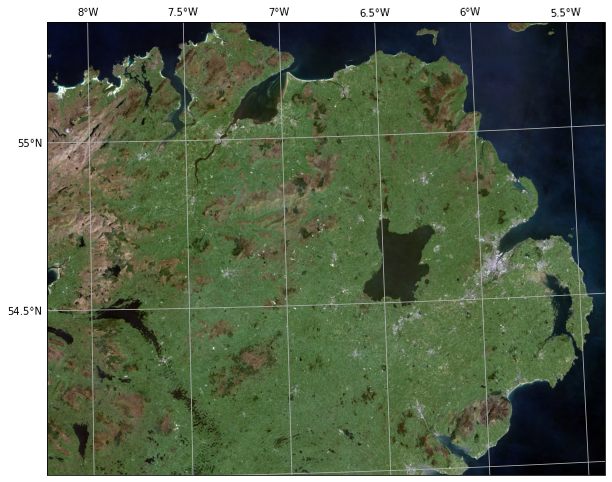

In [86]:
#display raster map
my_kwargs = {'extent': [xmin, xmax, ymin, ymax],
             'transform': myCRS}

my_stretch = {'pmin': 0.1, 'pmax': 99.9}

h, ax = img_display(img, ax, [2, 1, 0], stretch_args=my_stretch, **my_kwargs)
fig

In [87]:
# assign the county outlines 
county_outlines = ShapelyFeature(counties['geometry'], myCRS, edgecolor='r', facecolor='none')
#now add the the county outlines to the map
ax.add_feature(county_outlines)

In [88]:
#assign county handless (from wk3 practical)
county_handles = generate_handles([''], ['none'], edge='r')

In [89]:
#define color for a town or a city in the status column
def colormap():
    if row['towns.status'] == 'Town':
        return('g')
    if row['towns.status'] == 'City':
        return('r')
    else:
        return('b')

In [94]:
# assign and plot the the town handles/point
town_handles = ax.plot(towns.geometry.x, towns.geometry.y, 'H', ms=6, c=colormap, transform=myCRS)

ValueError: <function colormap at 0x000001795CCF0B80> is not a valid value for color

In [ ]:
# ax.legend() takes a list of handles and a list of labels corresponding to the objects you want to add to the legend
handles = county_handles + town_handles
labels = 'County Boundaries', ' Towns'

leg = ax.legend(handles, labels, title='Legend', title_fontsize=14,
                 fontsize=12, loc='upper left', frameon=True, framealpha=1)


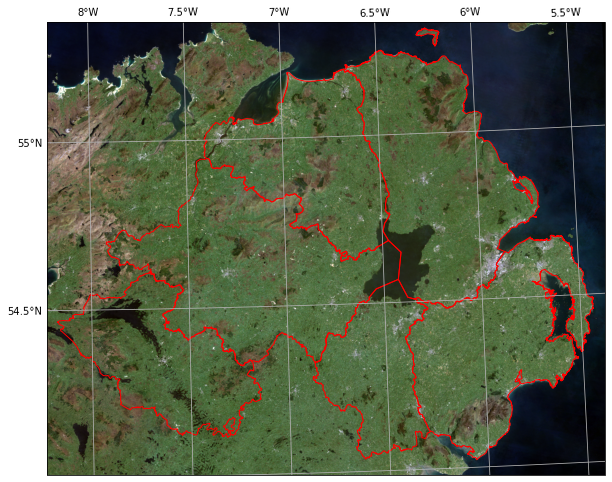

In [91]:
#display map again with with new layers
h, ax = img_display(img, ax, [2, 1, 0], stretch_args=my_stretch, **my_kwargs)
fig